# Notebook Contents and Objective:
This notebook contains details experiment of model evaluation and inference part

In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install transformers[sentencepiece]
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import json
from google.colab import data_table
import datasets
from datasets import Dataset, load_dataset, DatasetDict
import json
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use("dark_background")
import re
import random
from typing import Any, List, Tuple
from nltk import edit_distance
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



import transformers
from transformers import DonutProcessor, VisionEncoderDecoderConfig, VisionEncoderDecoderModel, BartConfig
from transformers import get_scheduler


import torch
print("CUDA available:", torch.cuda.is_available())
# from donut import DonutModel
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


# Progress bar
from tqdm.auto import tqdm

CUDA available: True


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cr

In [ ]:
## Reload the train and valid dataset dict
processed_trn_vld_loaded = load_dataset("indra-ami/docvqa_2400_train_valid")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
processed_trn_vld_loaded

DatasetDict({
    train: Dataset({
        features: ['question', 'docId', 'answers', 'data_split', 'bounding_boxes', 'word_list', 'image_raw', 'ground_truth'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['question', 'docId', 'answers', 'data_split', 'bounding_boxes', 'word_list', 'image_raw', 'ground_truth'],
        num_rows: 400
    })
})

In [ ]:
hf_train = processed_trn_vld_loaded['train']
hf_train

Dataset({
    features: ['question', 'docId', 'answers', 'data_split', 'bounding_boxes', 'word_list', 'image_raw', 'ground_truth'],
    num_rows: 2000
})

In [ ]:
# for i in hf_train['ground_truth']:
#   print(i, type(i))

In [ ]:
# hf_train['ground_truth'][107]

In [ ]:
# str_1 = '"Kool "C" with 0.63% menthol was implemented in April 1995"'
# str_1

In [ ]:
# str_2 = str_1.replace('"', '\\"')
# str_2

In [ ]:
# str_3 = str_1.replace('"', '\"')
# str_3

In [ ]:
# hf_train['ground_truth'][117]

In [ ]:
# for index,i in enumerate(hf_train['ground_truth']):
#   # print(index, i)
#   hf_train_json = json.loads(i)
#   print(index,hf_train_json)

In [ ]:
hf_valid = processed_trn_vld_loaded['valid']
hf_valid

Dataset({
    features: ['question', 'docId', 'answers', 'data_split', 'bounding_boxes', 'word_list', 'image_raw', 'ground_truth'],
    num_rows: 400
})

In [ ]:
model_checkpoint = "naver-clova-ix/donut-base"
# model_checkpoint = "naver-clova-ix/donut-base-finetuned-docvqa"
max_length = 128
image_size = [1280, 960]


config = VisionEncoderDecoderConfig.from_pretrained(model_checkpoint)
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length

processor = DonutProcessor.from_pretrained(model_checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint, config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## S-2: Creating PyTorch Donut Dataset Class

In [ ]:
from torch.utils.data import Dataset

In [ ]:
## Final Class by combining altogether

new_special_tokens_list = []
# list with the newly added tokens. The purpose of this list is to keep track of the tokens that were added to the tokenizer.

## DonutDataset class inherits from the torch.utils.data.Dataset class and overrides its methods

class DonutDataset(Dataset):
  """
  Args:
      dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
      max_length: the max number of tokens for the target sequences
      split: whether to load "train", "validation" or "test" split
      ignore_id: ignore_index for torch.nn.CrossEntropyLoss
      prompt_start_token: the special token at the start of the sequences
      prompt_end_token: the special token at the end of the sequences
      sort_json_key: whether or not to sort the JSON keys
  """

  def __init__(
    self,
    dataset_name_or_path: str,    # Name of the dataset or the path containing huggingface datset
    max_length: int,              # the maximum number of tokens for the target sequences/prompt
    split: str = None,
    ignore_id: int = -100,        # ignore_index for torch.nn.CrossEntropyLoss
    task_start_token: str = "<s>",
    prompt_start_token: str = None,   # The special token at the start of the propmpt sequences
    # prompt_end_token: str = None,   # The special token at the end of the prompt sequences
    sort_json_key: bool = True,       # Whether or not to sort the JSON keys
):
    super().__init__()

    ## Variable Declaration

    self.max_length = max_length
    self.split = split
    self.ignore_id = ignore_id
    self.task_start_token = task_start_token
    self.prompt_start_token = prompt_start_token if prompt_start_token else task_start_token
    # self.prompt_end_token = prompt_end_token
    self.sort_json_key = sort_json_key

    self.dataset = dataset_name_or_path
    self.dataset_length = len(self.dataset)   # The length of the dataset is stored

    self.gt_prompt_sequences = []    # operation for every single row  *** Note: same as hf_examples['gt_prompt'] which we did for single custom function case
    # list stores the ground truth (gt) token sequences, which are generated using the json2token() method for each sample in the dataset

    ## S-1: Iterate over all rows of the dataset and creating gt_prompt from gt_parses
    for sample in self.dataset:   # each sample is a dictionary

      # print(sample["ground_truth"], '|||||', type(sample["ground_truth"]))

      ground_truth_jsob_obj = json.loads(sample["ground_truth"])   # convert a string representation of ground_truth a JSON object
      if "gt_parses" in ground_truth_jsob_obj:  # when multiple ground truths are available, e.g., docvqa
        assert isinstance(ground_truth_jsob_obj["gt_parses"], list)
        gt_jsons_list = ground_truth_jsob_obj["gt_parses"]    ## Stores the list of gt_parses value as gt_parses is the only key
      else:
        assert "gt_parse" in ground_truth_jsob_obj and isinstance(ground_truth_jsob_obj["gt_parse"], dict)
        gt_jsons_list = [ground_truth_jsob_obj["gt_parse"]]


      ## Appending the prompt using list comprehension with adding cls_token before and eos_token at the end
      # For DOCVQA task
      self.gt_prompt_sequences.append(
            [
              # processor.tokenizer.cls_token +
              self.json2token(
                  # gt_jsons_list,
                  gt_json,
                  # update_special_tokens_for_json_key=self.split == "train",
                  sort_json_key=self.sort_json_key,
                )
              + processor.tokenizer.eos_token

              for gt_json in gt_jsons_list  # iterate over every dictionary json from the gt_jsons list
            ]
        )

    # self.added_tokens([self.prompt_start_token, self.prompt_end_token])
    self.added_tokens([self.task_start_token, self.prompt_start_token])
    self.prompt_start_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_start_token)
    # self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    # print(self.gt_prompt_sequences)

  ## S-2: Function converts an ordered JSON object into a token sequence
  def json2token(self, json_obj: Any,  sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(json_obj) == dict:
      if len(json_obj) == 1 and "text_sequence" in json_obj:
        return json_obj["text_sequence"]
      else:
        output = ""
        if sort_json_key:
          keys = sorted(json_obj.keys(), reverse=True)
        else:
          keys = json_obj.keys()

        for k in keys:
          # if update_special_tokens_for_json_key:
            # self.add_tokens([fr"", fr""])
          self.added_tokens([fr"<s_{k}>", fr"</s_{k}>"])
          output += (
              fr"<s_{k}>"
              + self.json2token(json_obj[k], sort_json_key)
              + fr"</s_{k}>"
          )
        return output

    elif type(json_obj) == list:
      return r"<sep/>".join([self.json2token(item, sort_json_key) for item in json_obj])

    else:
      json_obj = str(json_obj)
      if f"<{json_obj}/>" in new_special_tokens_list:
        json_obj = f"<{json_obj}/>"  # for categorical special tokens
      return json_obj

  ## S-3: Custom function to add new starting and ending prompt tokens and embed it
  def added_tokens(self, list_of_tokens: List[str]):
    """
    Add special tokens to tokenizer and resize the token embeddings of the decoder
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
      model.decoder.resize_token_embeddings(len(processor.tokenizer))
      new_special_tokens_list.extend(list_of_tokens)

  ## S-4: Aligns the dataset length with the valid indices
  def __len__(self) -> int:
    return self.dataset_length - 1

  ## S-5: special method that allows objects to support indexing and accessing their elements using square bracket notation ([]).
  # It is invoked when you use square brackets to access an element of an object, like obj[key]
  def __getitem__(self, indx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Load image from image_path of given dataset_path and convert into input pixel value tensor
    Convert ground truth data into input_ids (tokenized string) which is nothing but decoder input ids
    Create clone tensor of decoder input ids for masking and model understanding task
    Returns:
        input_tensor : preprocessed image
        input_ids : tokenized gt_data
        labels : masked labels (model doesn't need to predict prompt and pad token)
    """
    sample = self.dataset[indx]

    # S-5.1: create input_tensor from image i.e pixel values
    try:
      ## ** Note: This image path part will vary as per task
      # pixel_values = processor(Image.open(sample['full_path_image']).convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
      pixel_values = processor(sample['image_raw'].convert("RGB"), random_padding = self.split =="train",
                               return_tensors="pt").pixel_values
      # torch.Size([1, 3, 2560, 1920]) shape before squeeze
      input_tensor_pixel = pixel_values.squeeze()

    except Exception as e:
      print(sample)
      print(f"Error: {e}")
      return {}

    # S-5.2: tokenize document and creating decoder input ids

    # processed_gt_prompt = self.gt_prompt_sequences[indx]  # can be more than one, e.g., DocVQA Task 1
    # random.choice() is in scenarios where you need to select a random element from a collection of items.
    processed_gt_prompt = random.choice(self.gt_prompt_sequences[indx])  # can be more than one, e.g., DocVQA Task 1
    decoder_input_ids = processor.tokenizer(
        processed_gt_prompt,
        add_special_tokens=False,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)   #torch.Size([1, 128]) before squeeze

    # S-5.3: Create labels which is clone tensor for extracted values from decoder input ids tensors

    if self.split == "train":

      labels = decoder_input_ids.clone()    ## clone tensor of decoder input ids

      prompt_start_token_id_index = (labels == self.prompt_start_token_id).nonzero
      # prompt_end_token_id_index = (labels == self.prompt_end_token_id).nonzero

      labels[
          labels == processor.tokenizer.pad_token_id
      ] = self.ignore_id

      labels[
          : prompt_start_token_id_index().squeeze() + 1
      ] = self.ignore_id

      # ## Creating empty integer unmask tensor
      # unmask = torch.tensor([], dtype=torch.int)

      # ## iterate over both start and end tensor simulteneously
      # for start_index,end_index in zip(prompt_start_token_id_index(), prompt_end_token_id_index()):
      #   val_extracted = labels[start_index.squeeze()+1:end_index.squeeze()]     ## stores all extarcted values
      #   unmask = torch.cat((unmask, val_extracted))     ## concatenating start and end index value

      # labels[~torch.isin(labels, unmask)] =  self.ignore_id       ## assign with ignore id

      return input_tensor_pixel, decoder_input_ids, labels

    else:

      prompt_start_index = ((decoder_input_ids == self.prompt_start_token_id).nonzero)().squeeze()  # return prompt end index instead of target output labels

      # prompt_start_index = ((decoder_input_ids == self.prompt_start_token_id).nonzero)().squeeze()  # return prompt end index instead of target output labels

      return input_tensor_pixel, decoder_input_ids, prompt_start_index, processed_gt_prompt




In [ ]:
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

In [ ]:
train_dataset_sub = DonutDataset(hf_train, max_length=max_length, split="train",
                            task_start_token="<s_docvqa>", prompt_start_token="<s_answer>",
                            # prompt_end_token="</s_answer>",
                            sort_json_key=False,
                             )

valid_dataset_sub = DonutDataset(hf_valid, max_length=max_length,split="valid",
                            task_start_token="<s_docvqa>", prompt_start_token="<s_answer>",
                            # prompt_end_token="</s_answer>",
                            sort_json_key=False,
                             )

In [ ]:
train_dataset_sub, len(train_dataset_sub)

(<__main__.DonutDataset at 0x7eace5c9e8c0>, 1999)

In [ ]:
valid_dataset_sub, len(valid_dataset_sub)

(<__main__.DonutDataset at 0x7eace5c9f6d0>, 399)

In [ ]:
train_dataset_sub[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([57525, 27973, 52743, 48941, 44960, 40053, 35647, 25515, 54964, 36322,
   

In [ ]:
## Sample check of row 0 of train dataset
pixel_values_0, decoder_input_ids_0, labels_0  = train_dataset_sub[0]
for decoder_input_id, label in zip(decoder_input_ids_0.tolist()[:-1][:30], labels_0.tolist()[1:][:30]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_question> -100
what -100
is -100
the -100
date -100
mention -100
ed -100
in -100
this -100
letter -100
? -100
</s_question> -100
<s_answer> 1
1 /8
/8 /
/ 93
93 </s_answer>
</s_answer> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


In [ ]:
## Sample check of row 1 from training dataset
pixel_values_1, decoder_input_ids_1, labels_1  = train_dataset_sub[1]
for decoder_input_id, label in zip(decoder_input_ids_1.tolist()[:-1][:30], labels_1.tolist()[1:][:30]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_question> -100
what -100
is -100
the -100
contact -100
person -100
name -100
mention -100
ed -100
in -100
letter -100
? -100
</s_question> -100
<s_answer> p
p .
. carte
carte r
r </s_answer>
</s_answer> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


In [ ]:
valid_dataset_sub[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([57525, 42543, 52743, 48941, 22621, 26468, 39288, 33855, 37448,  4074,
   

In [ ]:
## Sample check of row 1 from valid dataset
pixel_values_1, decoder_input_ids_1, prompt_start_index_1, processed_gt_prompt_1  = valid_dataset_sub[1]
print(pixel_values_1)
print('******************************************')
print(processor.decode(decoder_input_ids_1))
print('******************************************')
print(prompt_start_index_1)
print('******************************************')
print(processed_gt_prompt_1)

tensor([[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])
******************************************
<s_question> What is name of university?</s_question><s_answer>

## S-3: Model Training Phase

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Empty cache
torch.cuda.empty_cache()

In [ ]:
train_dataloader_sub = DataLoader(train_dataset_sub, batch_size=1, shuffle = True, num_workers = 4)
valid_dataloader_sub = DataLoader(valid_dataset_sub, batch_size=1, shuffle = False, num_workers = 4)

In [ ]:
len(train_dataloader_sub), len(valid_dataloader_sub)

(1999, 399)

In [ ]:
batch = next(iter(train_dataloader_sub))
pixel_values, decoder_input_ids, labels = batch
print(pixel_values.shape)
print(decoder_input_ids.shape)
print(labels.shape)

torch.Size([1, 3, 1280, 960])
torch.Size([1, 128])
torch.Size([1, 128])


In [ ]:
pixel_values

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])

In [ ]:
decoder_input_ids

tensor([[57525, 36700, 48557, 48941, 44957, 22959, 43357, 52250, 54915, 46293,
         36209, 57526, 57527, 50956, 44028, 35815, 34996, 57528,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
labels

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100, 50956, 44028, 35815, 34996, 57528,     2,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  

In [ ]:
for decoder_input_id, label in zip(decoder_input_ids[0].tolist()[:-1][:30], labels[0].tolist()[1:][:30]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_question> -100
when -100
did -100
the -100
F -100
TC -100
first -100
publish -100
a -100
notice -100
? -100
</s_question> -100
<s_answer> November
November 11
11 ,
, 1974
1974 </s_answer>
</s_answer> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


In [ ]:
len(processor.tokenizer)

57530

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(["<s_answer>"])[0]
## Note:
# Setting the decoder start token ID in the model's configuration to the ID of the <s_answer> token in the tokenizer.
# This token is used to indicate the start of the target sequence during decoding.

In [ ]:
config = {
    "verbose": True
}

In [ ]:
## Cosine Similarity Score of answer from whole string

def calculate_cosine_similarity(prediction, actual):
  start_token = "<s_answer>"
  # end_token = "</s_answer>"

  # Extract the <s_answer> and </s_answer> substrings
  prediction_answer = prediction[prediction.index(start_token) + len(start_token):]
  actual_answer = actual[actual.index(start_token) + len(start_token):]

  # Vectorize the extracted answers
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform([prediction_answer, actual_answer])

  # Calculate cosine similarity
  similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
  return similarity_score



In [ ]:
## Learning rate scheduler
# optimizer = optim.SGD(model.parameters(), lr=lr)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)    # Linear rate scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)       # Exponential rate scheduler

# def lr_lambda(epoch):
#     # LR to be 0.1 * (1/1+0.01*epoch)
#     base_lr = 0.1
#     factor = 0.01
#     return base_lr/(1+factor*epoch)
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)   # for custom LR

# lambda1 = lambda epoch : epoch/10  #For each epoch, multiply epoch/10 * initial_lr
# lr_scheduler = lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda1)

In [ ]:
## Finding Training Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Set the optimizer
optimizer = Adam(model.parameters(), lr=3e-5)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
lambda1 = lambda epoch : epoch/10  #For each epoch, multiply epoch/10 * initial_lr
scheduler = lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda1)

# Set the number of training epochs
num_epochs = 10

## Set up empty list to keep track of model progress
epoch_count = []
train_losses = []
accs = []
val_mean_accuracy = []

for epoch in range(num_epochs):

  # Training loop
  model.train()

  print(f"Epoch {epoch + 1}/{num_epochs}")

  total_loss = 0.0    # Total loss across all batches in an epoch
  total_correct = 0   # Total correct across all batches in an epoch
  total_samples = 0   # Effective when batch_size is more than 1
  total_samples_mask_level = 0 # Total number of non-padding and ignored tokens

  # Iterate over the training dataset
  for pixel_values, decoder_input_ids, labels in tqdm(train_dataloader_sub):

    pixel_values = pixel_values.to(device)
    decoder_input_ids = decoder_input_ids.to(device)
    labels = labels.to(device)

    ## Finding outputs prediction
    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids[:, :-1], labels=labels[:, 1:])
    # print(outputs['loss'].shape, outputs['logits'].shape, outputs['encoder_last_hidden_state'].shape)

    ## Compute  the Loss
    loss = outputs.loss
    total_loss += loss.item()

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Compute the Accuracy (3-Ways)
    ## Pro-2
    total_samples += labels.size(0)   # # labels.size(0) = 1

    ## Pro-3 Mask level
    # Create a mask to exclude padding tokens & ignored tokens from accuracy calculation
    mask = (labels != -100)
    # Update the total number of non-padding tokens
    total_samples_mask_level += mask.sum().item()

    # Finding logits value
    logits = outputs.logits
    predictions = logits.argmax(dim=-1) # index value of maximum score for each token
    correct = (predictions == labels[:, 1:]).sum().item()    ## Number of correct in each row
    total_correct += correct    # Cumulative correct then lastly total correct prediction from each epoch

  scheduler.step()

  ## Average Loss Calculation
  avg_epoch_loss_batch_level = total_loss / len(train_dataloader_sub)   # average loss per batch i.e. normalize the loss value

  # Append the training losses and epoch count for plotting
  train_losses.append(avg_epoch_loss_batch_level)
  epoch_count.append(epoch)

  ## Average Accuracy Calculation
  avg_epoch_accuracy_batch_level = total_correct / len(train_dataloader_sub) # average per epoch accuracy at batch level (meaningful when batch size > 1)

  avg_epoch_accuracy_sample_level = total_correct / total_samples # average per epoch accuracy at based total number of data point

  avg_epoch_accuracy_mask_level = (total_correct / total_samples_mask_level) * 100 # average per epoch accuracy at based on mask or non padding tokens

  # If batch_size = 1 , so we can use anything len(train_dataloader_sub) or  len(train_dataset)

  print(f"Training Loss Batch Level: {avg_epoch_loss_batch_level:.4f} :::: Training Accuracy Batch Level: {avg_epoch_accuracy_batch_level:.3f}%")
  print(f"Training Accuracy Entire Sample Level: {avg_epoch_accuracy_sample_level:.3f}% :::: Training Accuracy Mask Level: {avg_epoch_accuracy_mask_level:.3f}%")
  print('*****************************************************************************************************************************')


  ## Validation section using Cosine Similarity
  model.eval()
  with torch.no_grad():
    for pixel_values, decoder_input_ids, prompt_start_indx, gt_prompt in tqdm(valid_dataloader_sub):
      # print(batch) ## printing all the details of four values in each row i.e pixel value, decoder_input_ids, prompt start token index and gt_prompt
      # print('*************************************************')

      pixel_values = pixel_values.to(device)
      decoder_input_ids = decoder_input_ids.to(device)
      prompt_start_indx = prompt_start_indx.to(device)
      gt_prompt = gt_prompt

      # print(pixel_values.shape, decoder_input_ids.shape, prompt_start_indx.shape)

      # # for decoder_input_id, ans_start_indx in zip(decoder_input_ids, prompt_start_indx):
      # #   print(decoder_input_id, ans_start_indx)

      decoder_input_question_ids = pad_sequence(
              [decoder_input_id[ : ans_start_indx + 1] for decoder_input_id, ans_start_indx in zip(decoder_input_ids, prompt_start_indx)],
              batch_first=True,
          )


      # print(decoder_gt_question_prompt, decoder_gt_question_prompt.shape)
      # e.g tensor([[    0, 57525, 42543, .... 36209, 57526, 57527]]) , torch.Size([1, 20])
      # print('*************************************************')

      outputs_gen = model.generate(pixel_values,
                                  decoder_input_ids = decoder_input_question_ids,
                                  max_length=max_length,
                                  early_stopping=True,
                                  pad_token_id=processor.tokenizer.pad_token_id,
                                  eos_token_id=processor.tokenizer.eos_token_id,
                                  use_cache=True,
                                  num_beams=1,
                                  bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                  return_dict_in_generate=True,
                                  )

      # print(outputs_gen)
      # print(outputs_gen.sequences)
      # generated_sequences = outputs_gen.sequences
      # for sequence in generated_sequences:
      #   generated_text = processor.tokenizer.decode(sequence, skip_special_tokens=True)
      #   print(generated_text)

      # Process and evaluate the predictions and answers
      predictions = []
      for seq in processor.tokenizer.batch_decode(outputs_gen.sequences):
        # print(seq)
        seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
        seq = re.sub(r"<.*?>", "", seq, count=1).strip()
        # print(seq)
        predictions.append(seq)
      # print(predictions)

      scores = []
      for pred_prompt, actual_prompt in zip(predictions, gt_prompt):
        # print(pred_prompt)
        # print(actual_prompt)
        pred_prompt = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred_prompt)
        # print(pred_prompt)
        actual_prompt = re.sub(r"<.*?>", "", actual_prompt, count=1)
        actual_prompt = actual_prompt.replace(processor.tokenizer.eos_token, "")
        # print(actual_prompt)

        # model.get_encoder
        # # Calculate cosine similarity between pred_prompt and actual_prompt
        # pred_vector = model.get_encoder(pred_prompt)  # Replace 'model.encode' with the actual encoding function of your model
        # actual_vector = model.get_encoder(actual_prompt)  # Replace 'model.encode' with the actual encoding function of your model
        similarity_score = calculate_cosine_similarity(pred_prompt, actual_prompt)
        scores.append(similarity_score)
        accs.append(scores[0])


        # print(scores)

        if config.get("verbose", False) and len(scores) == 1:
          print(f"Predicted Answer: {pred_prompt}")
          print(f"Actual Answer: {actual_prompt}")
          print(f"Similarity Score: {scores[0]}")

      print('++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++')

  mean_acc = np.mean(accs)  # Calculate the mean accuracy score
  val_mean_accuracy.append(mean_acc)
  accuracy_percentage = mean_acc * 100  # Calculate the accuracy percentage

  print(f"Mean Validation Accuracy Score after Epoch {epoch + 1} is: {accuracy_percentage:.4f}")

  print(f"------------------------------------------>>> End of {epoch + 1} <<<-------------------------------------------------------")



Epoch 1/10


  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 11.7738 :::: Training Accuracy Batch Level: 0.555%
Training Accuracy Entire Sample Level: 0.555% :::: Training Accuracy Mask Level: 7.090%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>C. C. C. C...................................................
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.0
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>, ..... ....................................................
Actual Answer: What is name of university?</s_question><s_answer>university of california</s_answer>
Similarity Score: 0.0
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>。 。 。 。 。 。 。 。 。 。 。 。,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actual Answer: Wha

  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 3.4585 :::: Training Accuracy Batch Level: 4.207%
Training Accuracy Entire Sample Level: 4.207% :::: Training Accuracy Mask Level: 54.241%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>To</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>university of california</s_answer>
Similarity Score: 0.22028815056182974
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 0.0
+++++++++++++++++++++++++++++++++

  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 1.7936 :::: Training Accuracy Batch Level: 5.468%
Training Accuracy Entire Sample Level: 5.468% :::: Training Accuracy Mask Level: 69.450%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>California, SAN DIEGO</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>University of California</s_answer>
Similarity Score: 0.3360969272762575
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>4</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Limited</s_answer>
Similarity Score: 0.44943

  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 1.4166 :::: Training Accuracy Batch Level: 5.718%
Training Accuracy Entire Sample Level: 5.718% :::: Training Accuracy Mask Level: 73.514%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>California, SAN DIEGO</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>University of California</s_answer>
Similarity Score: 0.3360969272762575
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>4</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 0.44943

  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 1.1248 :::: Training Accuracy Batch Level: 6.015%
Training Accuracy Entire Sample Level: 6.015% :::: Training Accuracy Mask Level: 77.300%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1950</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>California, SAN DIEGO</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>university of california, san diego</s_answer>
Similarity Score: 0.7092972666062738
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TTC's brands. An Asset for the nation</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>i

  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 0.9462 :::: Training Accuracy Batch Level: 6.240%
Training Accuracy Entire Sample Level: 6.240% :::: Training Accuracy Mask Level: 79.962%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1950</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>UNIVERSITY OF CALIFORNIA, SAN DIEGO</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>University of California</s_answer>
Similarity Score: 0.7092972666062738
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>TTC's Brands</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>


  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 0.7961 :::: Training Accuracy Batch Level: 6.430%
Training Accuracy Entire Sample Level: 6.430% :::: Training Accuracy Mask Level: 82.360%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>UNIVERSITY OF CALIFORNIA</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>university of california, san diego</s_answer>
Similarity Score: 0.7092972666062738
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>ACTORITION</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Si

  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 0.7245 :::: Training Accuracy Batch Level: 6.511%
Training Accuracy Entire Sample Level: 6.511% :::: Training Accuracy Mask Level: 83.688%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>1980</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>University of California, SandieGO</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>university of california, san diego</s_answer>
Similarity Score: 0.5803329846765686
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>The Coca-Dana</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited<

  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 0.6605 :::: Training Accuracy Batch Level: 6.567%
Training Accuracy Entire Sample Level: 6.567% :::: Training Accuracy Mask Level: 84.871%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.3</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.5797386715376658
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>University of California, SAN DIEGO</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>University of California</s_answer>
Similarity Score: 0.7092972666062738
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>The company's manager's leader</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>ITC Lim

  0%|          | 0/1999 [00:00<?, ?it/s]

Training Loss Batch Level: 0.6146 :::: Training Accuracy Batch Level: 6.638%
Training Accuracy Entire Sample Level: 6.638% :::: Training Accuracy Mask Level: 85.195%
*****************************************************************************************************************************


  0%|          | 0/399 [00:00<?, ?it/s]

Predicted Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>8.24</s_answer>
Actual Answer: What is the ‘actual’ value per 1000, during the year 1975?</s_question><s_answer>0.28</s_answer>
Similarity Score: 0.33609692727625756
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is name of university?</s_question><s_answer>of california</s_answer>
Actual Answer: What is name of university?</s_question><s_answer>university of california</s_answer>
Similarity Score: 0.7765145304745156
++++++++++++++++++++++++++++++++++++++++----------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
Predicted Answer: What is the name of the company?</s_question><s_answer>ITC's brands</s_answer>
Actual Answer: What is the name of the company?</s_question><s_answer>itc limited</s_answer>
Similarity Score: 0.50

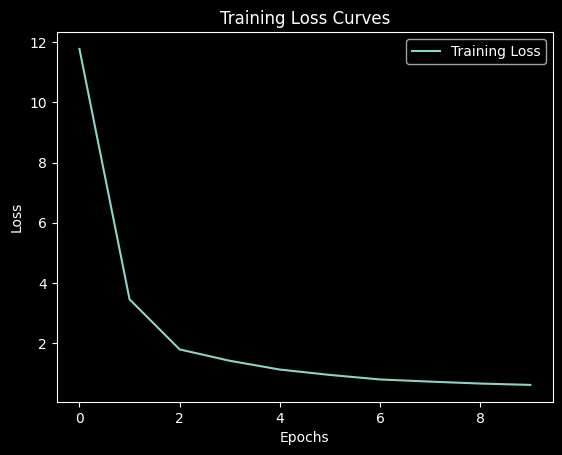

In [ ]:
plt.plot(epoch_count, train_losses, label='Training Loss')
plt.title("Training Loss Curves")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

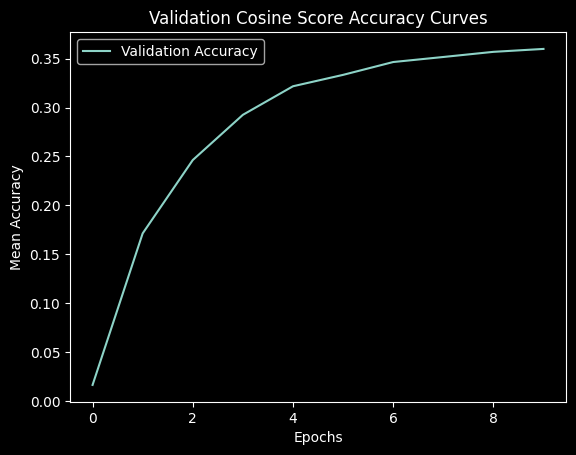

In [ ]:
plt.plot(epoch_count, val_mean_accuracy, label='Validation Accuracy')
plt.title("Validation Cosine Score Accuracy Curves")
plt.xlabel('Epochs')
plt.ylabel('Mean Accuracy')
plt.legend();

In [ ]:
# ## Validation section using Cosine Similarity
# model.eval()
# accs = []
# with torch.no_grad():
#   for pixel_values, decoder_input_ids, prompt_start_indx, gt_prompt in tqdm(valid_dataloader_sub):
#     # print(batch) ## printing all the details of four values in each row i.e pixel value, decoder_input_ids, prompt start token index and gt_prompt
#     # print('*************************************************')

#     pixel_values = pixel_values.to(device)
#     decoder_input_ids = decoder_input_ids.to(device)
#     prompt_start_indx = prompt_start_indx.to(device)
#     gt_prompt = gt_prompt

#     # print(pixel_values.shape, decoder_input_ids.shape, prompt_start_indx.shape)

#     # # for decoder_input_id, ans_start_indx in zip(decoder_input_ids, prompt_start_indx):
#     # #   print(decoder_input_id, ans_start_indx)

#     decoder_input_question_ids = pad_sequence(
#             [decoder_input_id[ : ans_start_indx + 1] for decoder_input_id, ans_start_indx in zip(decoder_input_ids, prompt_start_indx)],
#             batch_first=True,
#         )


#     # print(decoder_gt_question_prompt, decoder_gt_question_prompt.shape)
#     # e.g tensor([[    0, 57525, 42543, .... 36209, 57526, 57527]]) , torch.Size([1, 20])
#     # print('*************************************************')

#     outputs_gen = model.generate(pixel_values,
#                                  decoder_input_ids = decoder_input_question_ids,
#                                  max_length=max_length,
#                                  early_stopping=True,
#                                  pad_token_id=processor.tokenizer.pad_token_id,
#                                  eos_token_id=processor.tokenizer.eos_token_id,
#                                  use_cache=True,
#                                  num_beams=1,
#                                  bad_words_ids=[[processor.tokenizer.unk_token_id]],
#                                  return_dict_in_generate=True,
#                                  )

#     # print(outputs_gen)
#     # print(outputs_gen.sequences)
#     # generated_sequences = outputs_gen.sequences
#     # for sequence in generated_sequences:
#     #   generated_text = processor.tokenizer.decode(sequence, skip_special_tokens=True)
#     #   print(generated_text)

#     # Process and evaluate the predictions and answers
#     predictions = []
#     for seq in processor.tokenizer.batch_decode(outputs_gen.sequences):
#       # print(seq)
#       seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
#       seq = re.sub(r"<.*?>", "", seq, count=1).strip()
#       # print(seq)
#       predictions.append(seq)
#     # print(predictions)

#     scores = []
#     for pred_prompt, actual_prompt in zip(predictions, gt_prompt):
#       # print(pred_prompt)
#       # print(actual_prompt)
#       pred_prompt = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred_prompt)
#       # print(pred_prompt)
#       actual_prompt = re.sub(r"<.*?>", "", actual_prompt, count=1)
#       actual_prompt = actual_prompt.replace(processor.tokenizer.eos_token, "")
#       # print(actual_prompt)

#       # model.get_encoder
#       # # Calculate cosine similarity between pred_prompt and actual_prompt
#       # pred_vector = model.get_encoder(pred_prompt)  # Replace 'model.encode' with the actual encoding function of your model
#       # actual_vector = model.get_encoder(actual_prompt)  # Replace 'model.encode' with the actual encoding function of your model
#       similarity_score = calculate_cosine_similarity(pred_prompt, actual_prompt)
#       scores.append(similarity_score)
#       accs.append(scores[0])


#       # print(scores)

#       if config.get("verbose", False) and len(scores) == 1:
#         print(f"Predicted Answer: {pred_prompt}")
#         print(f"Actual Answer: {actual_prompt}")
#         print(f"Similarity Score: {scores[0]}")

#     print('***********************************************************************************************************************************************')



In [ ]:
# mean_acc = np.mean(accs)  # Calculate the mean accuracy score
# accuracy_percentage = mean_acc * 100  # Calculate the accuracy percentage

# print(f"Mean Validation Accuracy Score after Epoch {epoch + 1} is: {accuracy_percentage:.4f}")

In [ ]:
processor.save_pretrained("/content/drive/MyDrive/DOCVQA_Processed_Dataset/docvqa_sub_2600_wo_fuzz/processor_docvqa")

In [ ]:
# !huggingface-cli login  # ami

In [ ]:
model.push_to_hub("indra-ami/donut_docvqa_2600_base")

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/indra-ami/donut_docvqa_2600_base/commit/d03c2b4e97ff9b00de2c667976cc3f052427576b', commit_message='Upload model', commit_description='', oid='d03c2b4e97ff9b00de2c667976cc3f052427576b', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# !huggingface-cli login  # ami

In [ ]:
# new_model_checkpoint = "nielsr/donut-base-finetuned-docvqa"
# new_model_checkpoint = "nielsr/donut-docvqa-demo"
# new_model_checkpoint = "jinhybr/OCR-DocVQA-Donut"
loaded_processor = DonutProcessor.from_pretrained(new_model_checkpoint)
loaded_model = VisionEncoderDecoderModel.from_pretrained(new_model_checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## S-6.2: Inference check from User Input

In [ ]:
# new_model_checkpoint = "indra-ami/donut_docvqa_2600_base"
# loaded_processor = DonutProcessor.from_pretrained('indra-ami/donut_docvqa_2600_base')
# loaded_model = VisionEncoderDecoderModel.from_pretrained('indra-ami/donut_docvqa_2600_base')

In [ ]:
def token2json(seq_string):
  if "</s_answer>" in seq_string:
      start_tag = "<s_answer>"
      end_tag = "</s_answer>"
  else:
      seq_string = seq_string + "</s_answer>"
      start_tag = "<s_answer>"
      end_tag = "</s_answer>"

  start_index = seq_string.find(start_tag)  ## <
  end_index = seq_string.find(end_tag)      ## <

  if start_index != -1 and end_index != -1 and start_index < end_index:
    answer = seq_string[start_index + len(start_tag):end_index].strip()
    if not answer:
        answer = "No Answer Found"
    seq_string = seq_string[:start_index + len(start_tag)] + answer + seq_string[end_index:]

  result = loaded_processor.token2json(seq_string)
  return result

In [ ]:
## 2. test prediction from any image along with any question asked by the user input

# device = "cuda" if torch.cuda.is_available() else "cpu"
# loaded_model.to(device)

## Test Inference custom function for DOCVQA
def run_prediction(user_test_sample, model=loaded_model, processor=loaded_processor):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)

  user_test_image = Image.open(user_test_sample).convert("RGB")
  # display(user_test_image)

  pixel_values = processor(user_test_image, return_tensors="pt").pixel_values
  # print(pixel_values.shape)

  user_task_prompt = "<s_doCvqa><s_question>{user_input}</s_question><s_answer>"
  user_question =   str(input("Write your Question: "))                       ## "When is the coffee break?"
  prompt = user_task_prompt.replace("{user_input}", user_question)
  decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

  test_outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids = decoder_input_ids.to(device),
                               max_length = model.decoder.config.max_position_embeddings,
                               early_stopping = True,
                               pad_token_id = processor.tokenizer.pad_token_id,
                               eos_token_id = processor.tokenizer.eos_token_id,
                               use_cache = True,
                               num_beams = 1,
                               bad_words_ids = [[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate = True,
                               output_scores = True)

  test_seq_prediction = processor.batch_decode(test_outputs.sequences)[0]
  test_seq_prediction = test_seq_prediction.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
  test_seq_prediction = re.sub(r"<.*?>", "", test_seq_prediction, count=1).strip()  # remove first task start token
  # print(test_seq_prediction)

  test_seq_prediction_json = token2json(test_seq_prediction)
  # test_seq_prediction_json = processor.token2json(test_seq_prediction)

  return test_seq_prediction_json



In [ ]:
## User image path
test_img_1 = '/content/2020-11-25 to 2022-10-6 Clinical Note Cottage Health.pdfimage10.png'

user_json_result = run_prediction(test_img_1)
user_json_result

Write your Question: What is dob?


{'question': 'What is dob?', 'answer': '515/1982'}

In [ ]:
# seq1 = "<s_question>What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>"

In [ ]:
# seq1

In [ ]:
# result1 = processor.token2json(seq1)
# result1

In [ ]:
# type(result1)

In [ ]:
# seq2 ="<s_question>What the location address of NSDA?</s_question><s_answer>The best thing"

In [ ]:
# result2 = processor.token2json(seq2)
# result2

In [ ]:
# type(result2)

In [ ]:
# seq3 = "<s_question>What the location address of NSDA?</s_question><s_answer></s_answer>"

In [ ]:
# result3 = processor.token2json(seq3)
# result3

In [ ]:
# type(result3)

In [ ]:
# def end_question_finder(seq_string):
#   if "</s_answer>" in seq_string:
#     print("Present")
#   else:
#     seq_string = seq_string + "</s_answer>"
#     print("</s_answer> added" )
#     print(seq_string )

In [ ]:
# def end_question_finder(seq_string):
#     if "</s_answer>" in seq_string:
#         start_tag = "<s_answer>"
#         end_tag = "</s_answer>"
#     else:
#         seq_string = seq_string + "</s_answer>"
#         start_tag = "<s_answer>"
#         end_tag = "</s_answer>"

#     start_index = seq_string.find(start_tag)  ## <
#     end_index = seq_string.find(end_tag)      ## <

#     if start_index != -1 and end_index != -1 and start_index < end_index:
#       answer = seq_string[start_index + len(start_tag):end_index].strip()
#       if not answer:
#           answer = "No Answer Found"
#       seq_string = seq_string[:start_index + len(start_tag)] + answer + seq_string[end_index:]

#     result = processor.token2json(seq_string)
#     print(result)




In [ ]:
# seq_string = "<s_question>What the location address of NSDA?</s_question><s_answer></s_answer></s_answer></s_answer></s_answer></s_answer>"

In [ ]:
# end_question_finder(seq_string)